# CAD Challenge 2: 3-class classification

## Set things up

### Imports

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os.path
import os

import imgaug as ia
import imgaug.augmenters as iaa

import pickle

import dask
from dask.distributed import Client
import pandas as pd

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC

from skimage import io
from skimage.feature import fisher_vector, learn_gmm, daisy, graycomatrix, graycoprops, local_binary_pattern
from skimage.color import  rgb2hsv,  rgb2lab, rgb2yuv, rgb2gray
from skimage.util import img_as_ubyte, img_as_uint
from skimage.transform import resize

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb

### Set dataset location

In [2]:
parent_path = os.path.dirname(os.getcwd())

with open(parent_path + '\\dataset_path_2.txt', 'r') as file:
    dataset_path = file.read().strip()  # Use strip() to remove leading/trailing whitespace

### Set up matplotlib

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
#%matplotlib widget

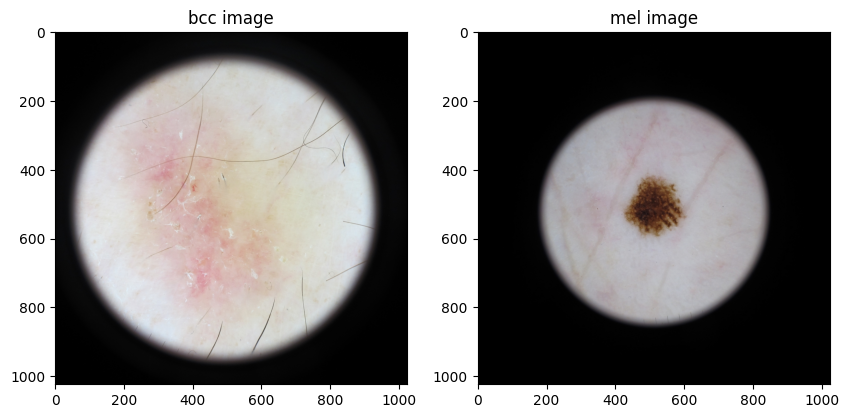

In [4]:
bcc_path = os.path.join(dataset_path, 'train', 'bcc')
mel_path = os.path.join(dataset_path, 'train', 'mel')
scc_path = os.path.join(dataset_path, 'train', 'scc')
bcc_val_path = os.path.join(dataset_path, 'val', 'bcc')
mel_val_path = os.path.join(dataset_path, 'val', 'mel')
scc_val_path = os.path.join(dataset_path, 'val', 'scc')
test_path = os.path.join(dataset_path, 'test', 'test')

# get the filenames of all the images
bcc_filenames = os.listdir(bcc_path)
mel_filenames = os.listdir(mel_path)
scc_filenames = os.listdir(scc_path)
bcc_val_filenames = os.listdir(bcc_val_path)
mel_val_filenames = os.listdir(mel_val_path)
scc_val_filenames = os.listdir(scc_val_path)
test_filenames = os.listdir(test_path)

# load some images for visualization
bcc_image = io.imread(os.path.join(bcc_path, bcc_filenames[4]))
mel_image = io.imread(os.path.join(mel_path, mel_filenames[11]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(bcc_image)
ax1.set_title('bcc image')
ax2.imshow(mel_image)
ax2.set_title('mel image')
plt.show()

# Data augmentation

In [5]:
# q, r = divmod(len(mel_filenames)-len(scc_filenames), len(scc_filenames))
# scc_filenames_rep = scc_filenames * q + scc_filenames[:r]

# q, r = divmod(len(mel_filenames)-len(bcc_filenames), len(bcc_filenames))
# bcc_filenames_rep = bcc_filenames * q + bcc_filenames[:r]

# print(len(bcc_filenames_rep), len(mel_filenames), len(scc_filenames_rep))

# ia.seed(42)

# seq_aug = iaa.Sequential([
#     iaa.CropAndPad(percent=(0, 0.4), pad_mode=ia.ALL), # random crops
#     iaa.Affine(rotate=(-90, 90), shear=(-20, 20), scale=(0.8, 1.2), mode='symmetric'), # apply affine transformations
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.Flipud(0.5), # vertically flip 50% of the images
#     iaa.WithColorspace(to_colorspace="HSV", from_colorspace="RGB", children=[
#         iaa.WithChannels(0, iaa.Multiply((-0.1, 0.1))), # shift hue by [-0.1, 0.1] percent
#         iaa.WithChannels(1, iaa.Multiply((0.7, 1.3))), # change saturation by [0.7, 1.3] percent
#         iaa.WithChannels(2, iaa.Multiply((0.7, 1.3))), # change brightness by [0.7, 1.3] percent
#     ]),
#     iaa.LinearContrast((0.7, 1.3)) # change contrast by [0.7, 1.3] percent
# ])

# # for each image in scc_filenames_rep, load it, apply the augmenter, and save it to the with the suffix _aug
# for i, filename in enumerate(scc_filenames_rep):
#     image = io.imread(os.path.join(scc_path, filename))
#     image_aug = seq_aug.augment_image(image)
#     io.imsave(os.path.join(scc_path, filename[:-4] + '_aug' + str(i) + filename[-4:]), image_aug)

# # for each image in bcc_filenames_rep, load it, apply the augmenter, and save it to the with the suffix _aug
# for i, filename in enumerate(bcc_filenames_rep):
#     image = io.imread(os.path.join(bcc_path, filename))
#     image_aug = seq_aug.augment_image(image)
#     io.imsave(os.path.join(bcc_path, filename[:-4] + '_aug' + str(i) + filename[-4:]), image_aug)

# # get the filenames of all the images
# bcc_filenames = os.listdir(bcc_path)
# mel_filenames = os.listdir(mel_path)
# scc_filenames = os.listdir(scc_path)
# bcc_val_filenames = os.listdir(bcc_val_path)
# mel_val_filenames = os.listdir(mel_val_path)
# scc_val_filenames = os.listdir(scc_val_path)

# Image Descriptors

## Color and texture descriptors

In [6]:
def set_colorspace(img, colorspace='rgb'):

    if colorspace == 'rgb':
        return img
    elif colorspace == 'hsv':
        img = rgb2hsv(img)
        return img
    elif colorspace == 'lab':
        img = rgb2lab(img)
        return img
    elif colorspace == 'yuv':
        img = rgb2yuv(img)
        return img
    else:
        raise Exception('invalid colorspace')


def colorHistogram(img, color_space='rgb', bins=[256,256,256], plot=False):

    if plot:
        colors = ['tab:orange', 'tab:purple', 'tab:cyan']
        fig, ax = plt.subplots(2,3, constrained_layout=True)    
    
    histograms = []

    for ci, c in enumerate(color_space):

        b = bins[ci]
        histogram = np.histogram(img[:,:,ci].flatten(), bins=b)

        if plot:
            ax[0,ci].imshow(img[:,:,ci], cmap='gray')

            ax[1,ci].bar(histogram[1][:-1], histogram[0], width=1,color=colors[ci])
            #add subplot title
            ax[1,ci].set_title(c.upper() + ' channel histogram')

        histograms.append(histogram)


    return histograms

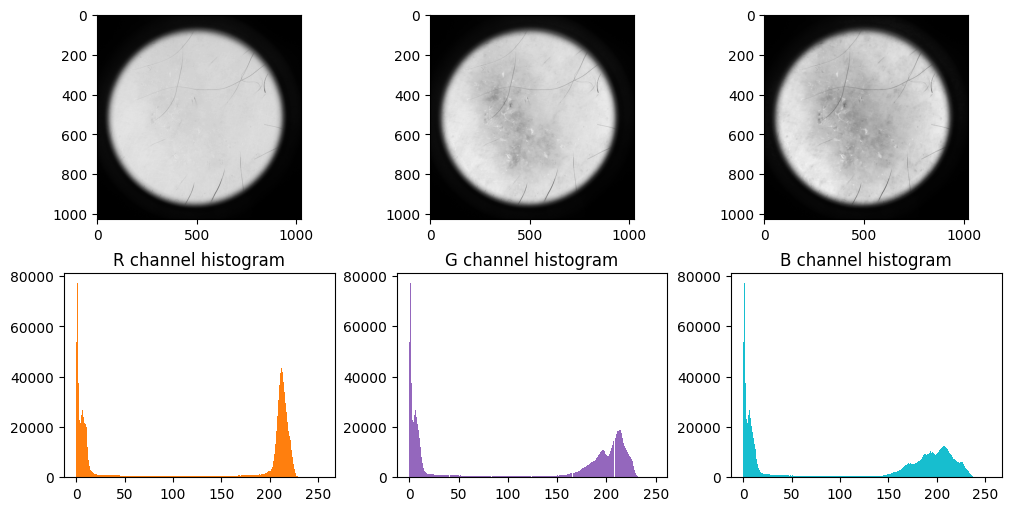

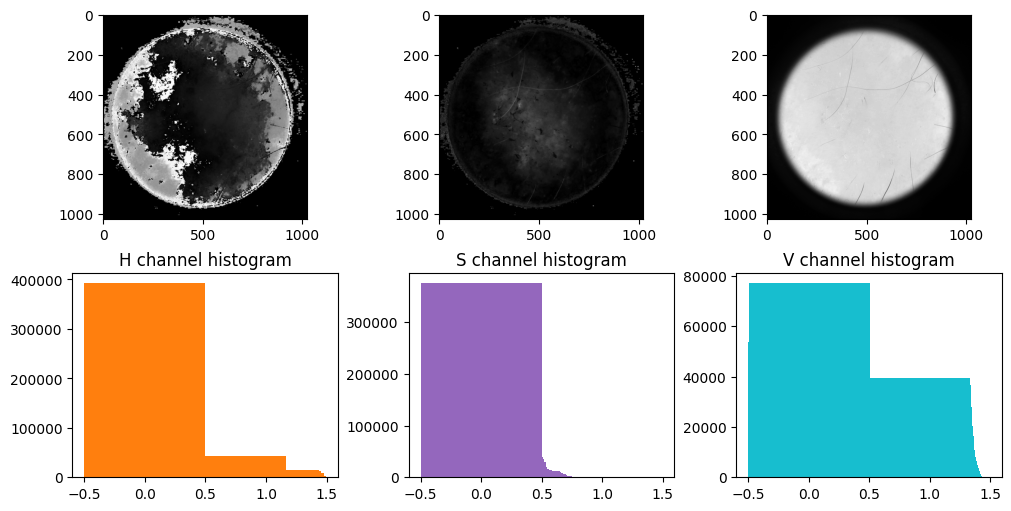

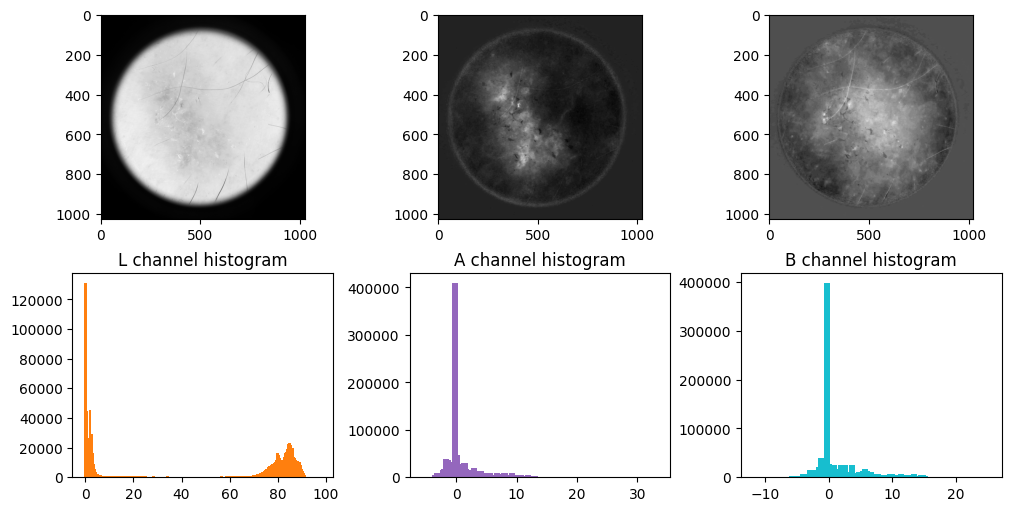

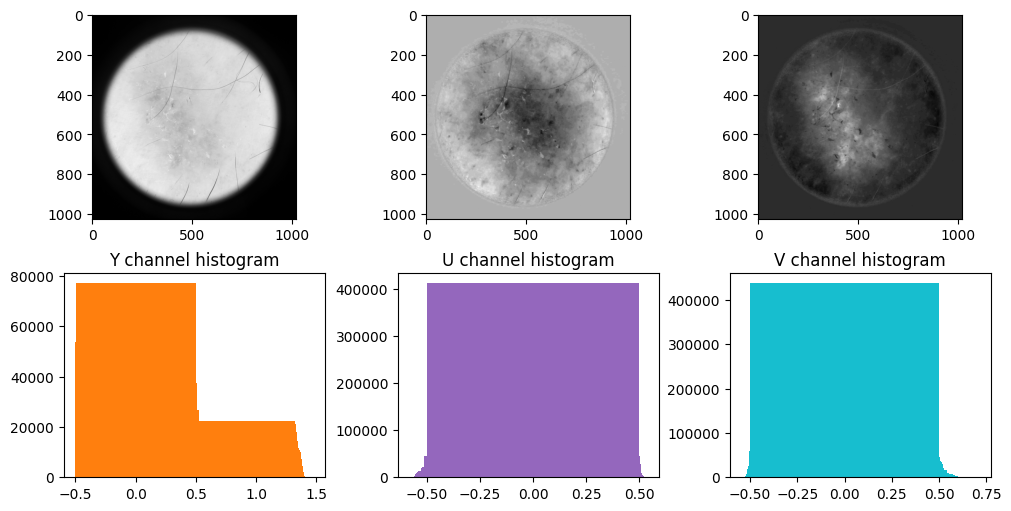

In [7]:
for cs in ['rgb', 'hsv', 'lab', 'yuv']:
    bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
    }

    img_cs = set_colorspace(bcc_image, cs)
    h = colorHistogram(img_cs, cs, bins[cs], plot=True)

In [8]:
# check the optimal number of bins for each color space and channel using the Freedman-Diaconis rule

# load sample image
image = io.imread(os.path.join(bcc_path, bcc_filenames[0]))
# image = io.imread(os.path.join(others_path, others_filenames[4]))

cs = ['rgb', 'hsv', 'lab', 'yuv']
bins = {}
for color_space in cs:
    bins_cs = []
    image_cs = set_colorspace(image, color_space)
    for i in range(image.shape[2]):
        bins_cs.append(np.histogram_bin_edges(image_cs[:,:,i], bins='fd').shape[0] - 1)

    bins[color_space] = bins_cs

print(bins)

{'rgb': [935, 409, 407], 'hsv': [643, 208, 1001], 'lab': [512, 290, 357], 'yuv': [504, 324, 255]}


In [9]:
# rgb color space represents an image as a 3D array of red, green, and blue channels
# each channel is a 2D array of pixel values ranging from 0 to 255

# hsv color space represents an image as a 3D array of hue, saturation, and value channels
# hue is the color, saturation is the amount of color, and value is the brightness of the color
# For HSV, hue range is [0,179], saturation range is [0,255], and value range is [0,255]. Different software
# use different scales. So if you are comparing OpenCV values with them, you need to normalize these ranges.

# lab color space represents an image as a 3D array of lightness, a, and b channels
# lightness is the brightness of the color, a is the green-red channel, and b is the blue-yellow channel
# L represents darkness to lightness, with values ranging from 0 to 100; a represents greenness to redness
# with values of -128 to +127; and b represents blueness to yellowness also with values from -128 to +127.

# yuv color space represents an image as a 3D array of luminance, u, and v channels
# luminance is the brightness of the color, u is the blue-luminance channel, and v is the red-luminance channel
# Y ranges from 0 to 1 (or 0 to 255 in digital formats), while U and V range from -0.5 to 0.5 (or -128 to 127
# in signed digital form, or 0 to 255 in unsigned form).

In [10]:
color_spaces = ['rgb', 'hsv', 'lab', 'yuv']

# Bin sizes for each color space
# Bins are used to discretize the values of each channel
bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
}

@dask.delayed
def extract_features(filename, input_path, output_path, color_spaces, bins):
    img = io.imread(input_path)

    features = {}

    features['filename'] = filename.split('.')[0]

    # mel, bcc, scc
    features['type'] = 'mel' if 'mel' in filename else 'bcc' if 'bcc' in filename else 'scc'

    features['label'] = 0 if 'mel' in filename else 1 if 'bcc' in filename else 2


    ## color features

    # create dictionary entries for each color space histogram
    for cs in color_spaces:
        # print(cs)
        img_cs = set_colorspace(img, cs)

        # loop through each channel of the image
        for i in range(image_cs.shape[2]):
             # calculate the histogram for the current channel using np.histogram and the number of bins
            hist_values, _ = np.histogram(img_cs[:,:,i], bins=bins[cs][i], density=False)

            # print(hist_values.shape)
        
            # Loop through each bin and create a key with the channel and bin number
            for j in range(len(hist_values)):
                # Append the histogram value to the dictionary with the key as color_space_channel_bin
                features[cs + "_" + cs[i] + "_" + str(j+1)] = hist_values[j] # Use single value instead of array

    
    ## texture features

    # GLCM parameters and properties
    distances = [1, 2, 3, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # [0, 45, 90, 135]
    properties = ['dissimilarity', 'correlation', 'contrast', 'homogeneity', 'energy', 'ASM']

    # settings for LBP
    radius = 3
    n_points = 8 * radius

    # convert to grayscale
    img_g = rgb2gray(img)

    # convert to integer dtype for LBP
    img_g = img_as_uint(img_g)

    # calculate LBP
    lbp = local_binary_pattern(img_g, n_points, radius, 'uniform')

    # number of bins
    n_bins = int(lbp.max() + 1)

    # calculate histogram
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))

    # append histogram to list
    for i in range(len(hist)):
        features['lbp_{}'.format(i)] = hist[i]

    # convert to 8-bit
    img_8bit = img_as_ubyte(img_g)

    # calculate GLCM
    glcm = graycomatrix(img_8bit, distances, angles)

    # plt.figure()
    # plt.imshow(glcm[:,:,0,0], cmap='gray')

    for prop in properties:
        res = graycoprops(glcm, prop)

        for i in range(len(distances)):
            for j in range(len(angles)):
                features['glcm_{}_{}_{}'.format(prop, distances[i], int(angles[j]*180/np.pi))] = res[i, j]


    ## save features to pickle file

    # if parent path does not exist, create it
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))

    # save pikle file
    with open(output_path, 'wb') as f:
        pickle.dump(features, f)

    # print(features)

    # return features

In [11]:
# start the dask client for parallel processing

client = Client(n_workers=8, threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 63.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58212,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 63.85 GiB
Comm: tcp://127.0.0.1:58262,Total threads: 2
Dashboard: http://127.0.0.1:58263/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:58215,


In [12]:
# type_path: 'train', 'val' or 'test'
# type_tissue: 'bcc', 'mel', 'scc' or 'test'
def extract_features_for_filenames(filenames, type_path, type_tissue):
    results = []

    for filename in filenames:

        input_path = os.path.join(dataset_path, type_path, type_tissue, filename)

        output_path = os.path.join(dataset_path, 'features', 'color_and_texture_temp', type_path, type_tissue, filename.split('.')[0] + '.pkl')

        # check if the file already exists
        if os.path.isfile(output_path):
            continue

        result = extract_features(filename, input_path, output_path, color_spaces, bins)
        results.append(result)

    dask.compute(results)


extract_features_for_filenames(bcc_filenames, 'train', 'bcc')
extract_features_for_filenames(mel_filenames, 'train', 'mel')
extract_features_for_filenames(scc_filenames, 'train', 'scc')
extract_features_for_filenames(bcc_val_filenames, 'val', 'bcc')
extract_features_for_filenames(mel_val_filenames, 'val', 'mel')
extract_features_for_filenames(scc_val_filenames, 'val', 'scc')
extract_features_for_filenames(test_filenames, 'test', 'test')

client.close()

c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 24.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 25.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 24.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 24.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and 

In [13]:
output_path_color_and_texture = os.path.join(dataset_path, 'features', 'color_and_texture')

if os.path.exists(output_path_color_and_texture) is False:

    # create the folder
    if not os.path.exists(output_path_color_and_texture):
        os.makedirs(output_path_color_and_texture)

    # load all the features from the pickle files

    def load_features(filenames, type_path, type_tissue):
        features = []
        
        for filename in filenames:
            input_file = os.path.join(dataset_path, 'features', 'color_and_texture_temp', type_path, type_tissue, filename.split('.')[0] + '.pkl')

            with open(input_file, 'rb') as f:
                features.append(pickle.load(f))
        
        return features

    bcc_features = load_features(bcc_filenames, 'train', 'bcc')
    mel_features = load_features(mel_filenames, 'train', 'mel')
    scc_features = load_features(scc_filenames, 'train', 'scc')
    bcc_val_features = load_features(bcc_val_filenames, 'val', 'bcc')
    mel_val_features = load_features(mel_val_filenames, 'val', 'mel')
    scc_val_features = load_features(scc_val_filenames, 'val', 'scc')
    test_features = load_features(test_filenames, 'test', 'test')

    # create df with all the features
    df_bcc = pd.DataFrame(bcc_features)
    df_mel = pd.DataFrame(mel_features)
    df_scc = pd.DataFrame(scc_features)
    df_bcc_val = pd.DataFrame(bcc_val_features)
    df_mel_val = pd.DataFrame(mel_val_features)
    df_scc_val = pd.DataFrame(scc_val_features)
    df_test = pd.DataFrame(test_features)

    # concatenate the two dataframes
    df_train = pd.concat([df_bcc, df_mel, df_scc], ignore_index=True)
    df_val = pd.concat([df_bcc_val, df_mel_val, df_scc_val], ignore_index=True)

    # save df to pickle file
    df_train.to_pickle(os.path.join(output_path_color_and_texture, 'df_train.pkl'))
    df_val.to_pickle(os.path.join(output_path_color_and_texture, 'df_val.pkl'))
    df_test.to_pickle(os.path.join(output_path_color_and_texture, 'df_test.pkl'))

## Fisher vector features

In [14]:
# # start the dask client for parallel processing

# client = Client(n_workers=8, threads_per_worker=2)
# client

In [15]:
# @dask.delayed
# def extract_daisy_descriptors(filename, input_path):
#     img = io.imread(input_path)

#     # convert to grayscale
#     img = rgb2gray(img)

#     # resize image to 600 x 450 dimensions
#     img = resize(img, (600, 450), anti_aliasing=True)

#     # detector_extractor = SIFT()
#     # detector_extractor.detect(exposure.equalize_adapthist(img))
#     # detector_extractor.extract(img)
#     # # detector_extractor.detect_and_extract(img)
#     # return {'filename': filename.split('.')[0], 'orb': detector_extractor.descriptors.astype(np.float32)}

#     # descs = daisy(img, step=5, radius=5, rings=1, histograms=8,
#     #                      orientations=4)
#     # steps 50, radius 15 tried before
#     descs = daisy(img, step=40, radius=14, rings=1, histograms=8,
#                         orientations=4)
                         
#     # transform from 3D to 2D array
#     descs = descs.reshape(-1, descs.shape[-1])

#     return {'filename': filename.split('.')[0], 'daisy': descs}



# # type_path: 'train' or 'val'
# # type_tissue: 'nevus' or 'others'
# def process_images(filenames, type_path, type_tissue):
#     results = []

#     for filename in filenames:

#         input_path = os.path.join(dataset_path, type_path, type_tissue, filename)

#         result = extract_daisy_descriptors(filename, input_path)
#         results.append(result)

#     gathered = dask.compute(results)

#     return gathered

#     # if save_batch:
#     #     # save pikle file
#     #     with open(os.path.join(dataset_path, 'features', 'daisy_descriptors, f'{type_path}_{type_tissue}_daisy_descriptors.pkl', 'wb') as f:
#     #         pickle.dump(gathered, f)

#         # check if the file already exists

# output_path_fv_train = os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_train.pkl')
# output_path_fv_val = os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_val.pkl')

# if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
#     daisy_descriptors_bcc_train = process_images(bcc_filenames, 'train', 'bcc')
#     daisy_descriptors_mel_train = process_images(mel_filenames, 'train', 'mel')
#     daisy_descriptors_scc_train = process_images(scc_filenames, 'train', 'scc')
#     daisy_descriptors_bcc_val = process_images(bcc_val_filenames, 'val', 'bcc')
#     daisy_descriptors_mel_val = process_images(mel_val_filenames, 'val', 'mel')
#     daisy_descriptors_scc_val = process_images(scc_val_filenames, 'val', 'scc')

In [16]:
# client.close()

In [17]:
# if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
#     # add the results to a dataframe
#     df_daisy_desc_train = pd.DataFrame(daisy_descriptors_bcc_train[0] + daisy_descriptors_mel_train[0] + daisy_descriptors_scc_train[0])
#     df_daisy_desc_val = pd.DataFrame(daisy_descriptors_bcc_val[0] + daisy_descriptors_mel_val[0] + daisy_descriptors_scc_val[0])

#     # convert to list
#     daisy_train = df_daisy_desc_train['daisy'].values.tolist()
#     daisy_val = df_daisy_desc_val['daisy'].values.tolist()

In [18]:
# if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
#     # Train a K-mode GMM
#     k = 128
#     gmm = learn_gmm(daisy_train, n_modes=k)

In [19]:
# if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
#     # Compute the Fisher vectors
#     fv_train = np.array([
#         fisher_vector(descriptor_mat, gmm, improved=True)
#         for descriptor_mat in daisy_train
#     ])

#     fv_val = np.array([
#         fisher_vector(descriptor_mat, gmm, improved=True)
#         for descriptor_mat in daisy_val
#     ])


#     # create labels using the sizes of the training and testing sets, 'mel' = 0, 'bcc' = 1, 'scc' = 2
#     fv_train_labels = np.concatenate((np.zeros(len(daisy_descriptors_mel_train[0])), np.ones(len(daisy_descriptors_bcc_train[0])), np.full(len(daisy_descriptors_scc_train[0]), 2)))
#     fv_val_labels = np.concatenate((np.zeros(len(daisy_descriptors_mel_val[0])), np.ones(len(daisy_descriptors_bcc_val[0])), np.full(len(daisy_descriptors_scc_val[0]), 2)))


#     # train model
#     model = xgb.XGBClassifier(device='cuda', objective='multi:softprob', num_class=3, random_state=42, n_jobs=-1, verbosity=1)
#     model.fit(fv_train, fv_train_labels)

In [20]:
def evaluate_model(model, y_data, y_true, individual_class_results=False):

    # multi-class results
    print('Multi-class results')
    y_pred_proba = model.predict_proba(y_data)
    y_pred = model.predict(y_data)

    # classification_report
    print(classification_report(y_true, y_pred))

    # multi-class metrics, show two decimal places
    print('Accuracy:\t\t{0:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision:\t\t{0:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Recall:\t\t\t{0:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
    print('F1 score:\t\t{0:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

    print('\nCohen kappa:\t\t{0:.2f}'.format(cohen_kappa_score(y_true, y_pred)))
    print('Balanced accuracy:\t{0:.2f}'.format(balanced_accuracy_score(y_true, y_pred)))
    print('ROC AUC score:\t\t{0:.2f}'.format(roc_auc_score(y_true, y_pred_proba, multi_class='ovo', average='weighted')))

    if individual_class_results:
        # binary results for each class
        for class_name, class_n in [('mel', 0), ('bcc', 1), ('scc', 2)]:
            y_true_class = y_true == class_n

            print('\nClass {} results'.format(class_name))
            y_pred_proba_class = y_pred_proba[:, class_n]
            y_pred_class = y_pred_proba_class > 0.5

            # classification_report
            print(classification_report(y_true_class, y_pred_class))

            # metrics, show two decimal places
            print('Accuracy:\t{0:.2f}'.format(accuracy_score(y_true_class, y_pred_class)))
            print('Precision:\t{0:.2f}'.format(precision_score(y_true_class, y_pred_class)))
            print('Recall:\t\t{0:.2f}'.format(recall_score(y_true_class, y_pred_class)))
            print('F1 score:\t{0:.2f}'.format(f1_score(y_true_class, y_pred_class)))
            print('ROC AUC score:\t{0:.2f}'.format(roc_auc_score(y_true_class, y_pred_proba_class)))

            # plot the ROC curve
            fpr, tpr, _ = roc_curve(y_true_class, y_pred_proba_class)
            plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
            plt.plot([0,1], [0,1], 'k--', label='Random classifier')
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend()
            plt.show()

# if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
#     evaluate_model(model, fv_val, fv_val_labels)

In [21]:
# if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
#     # add fisher vectors (np.arrays) to columns in a df using concat with names 'fv_1', 'fv_2', etc.
#     df_fv_train = pd.DataFrame(fv_train, columns=['fv_{}'.format(i) for i in range(fv_train.shape[1])])
#     df_fv_val = pd.DataFrame(fv_val, columns=['fv_{}'.format(i) for i in range(fv_val.shape[1])])

#     # if parent path does not exist, create it
#     if not os.path.exists(os.path.dirname(output_path_fv_train)):
#         os.makedirs(os.path.dirname(output_path_fv_train))

#     # save the dataframes to pickle files
#     df_fv_train.to_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_train.pkl'))
#     df_fv_val.to_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_val.pkl'))

## Load features

In [22]:
# load color and texture features
df_train = pd.read_pickle(os.path.join(dataset_path, 'features', 'color_and_texture', 'df_train.pkl'))
df_val = pd.read_pickle(os.path.join(dataset_path, 'features', 'color_and_texture', 'df_val.pkl'))
df_test = pd.read_pickle(os.path.join(dataset_path, 'features', 'color_and_texture', 'df_test.pkl'))

# we don't use fisher vectors anymore, so we don't need to load them

# # load the fisher vector features
# df_fv_train = pd.read_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_train.pkl'))
# df_fv_val = pd.read_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_val.pkl'))

# # add fisher vectors to the dataframe
# df_train = pd.concat([df_train, df_fv_train], axis=1)
# df_val = pd.concat([df_val, df_fv_val], axis=1)

# Classification

In [23]:
# get 500 of each
# df_feat_s = pd.concat([resample(df[df['label'] == 1], n_samples=2500, random_state=42),
#                      resample(df[df['label'] == 0], n_samples=2500, random_state=42)], ignore_index=True)

df_train_s = df_train

# store the labels
y_train = df_train_s['label']
y_val = df_val['label']

columns_to_drop =  ['filename', 'type', 'label']

# include some features to drop
for cs in ['rgb', 'lab', 'yuv', 'fv_']:
    columns_to_drop.extend([col for col in df_train_s.columns if cs in col])


# drop the columns
df_train_s_d = df_train_s.drop(columns_to_drop, axis=1)
df_val_d = df_val.drop(columns_to_drop, axis=1)
df_test_d = df_test.drop(columns_to_drop, axis=1)


# assign to new variables for clarity
X_train = df_train_s_d
X_val = df_val_d
X_test = df_test_d

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5082, 994)
(1270, 994)
(2121, 994)


In [24]:
# from imblearn.combine import SMOTETomek

# sm = SMOTETomek(random_state=42)

# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# print(X_train_res.shape)
# print(y_train_res.shape)

In [25]:
# standard scale for PCA
sd_scaler = StandardScaler()
X_train_scaled = sd_scaler.fit_transform(X_train)
X_val_scaled = sd_scaler.transform(X_val)
X_test_scaled = sd_scaler.transform(X_test)
# X_train_res_scaled = sd_scaler.transform(X_train_res)

# # apply PCA
# pca = PCA(n_components=.999, random_state=42)
# X_train_scaled_pca = pca.fit_transform(X_train_scaled)
# X_val_scaled_pca = pca.transform(X_val_scaled)

# # min-max normalization
# mm_scaler = MinMaxScaler()
# X_train_scaled_pca_norm = mm_scaler.fit_transform(X_train_scaled_pca)
# X_val_scaled_pca_norm = mm_scaler.transform(X_val_scaled_pca)

# # recover columns names
# X_train_scaled_pca_norm = pd.DataFrame(X_train_scaled_pca_norm, columns=pca.get_feature_names_out(), index=X_train.index)
# X_val_scaled_pca_norm = pd.DataFrame(X_val_scaled_pca_norm, columns=pca.get_feature_names_out(), index=X_val.index)

# print(X_train_scaled_pca_norm.shape)
# print(X_val_scaled_pca_norm.shape)

In [26]:
X = X_train_scaled
y = y_train

In [27]:
# # feature selection

# # select features using ANOVA F-value test
# f_selector = SelectKBest(f_classif, k=100)
# X_train_scaled_f = f_selector.fit_transform(X_train_scaled, y_train)
# X_val_scaled_f = f_selector.transform(X_val_scaled)

# # train model
# xgb_m_f = xgb.XGBClassifier(device='cuda', objective='binary:logistic', random_state=42, n_jobs=-1, verbosity=1)
# xgb_m_f.fit(X_train_scaled_f, y_train)

In [28]:
# train model

xgb_m = xgb.XGBClassifier(class_weight='balanced', device='cuda', objective='multi:softprob', num_class=3, random_state=42, n_jobs=-1, verbosity=0, n_estimators=1000)
xgb_m.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1, num_class=3, ...)

In [29]:
cat_m = CatBoostClassifier(auto_class_weights='Balanced', iterations=1000, task_type="GPU", devices='0:1')
cat_m.fit(X, y)

Learning rate set to 0.09043
0:	learn: 1.0662457	total: 104ms	remaining: 1m 43s
1:	learn: 1.0381584	total: 122ms	remaining: 1m 1s
2:	learn: 1.0131693	total: 139ms	remaining: 46.3s
3:	learn: 0.9900617	total: 156ms	remaining: 38.9s
4:	learn: 0.9707802	total: 175ms	remaining: 34.7s
5:	learn: 0.9521537	total: 192ms	remaining: 31.8s
6:	learn: 0.9352056	total: 210ms	remaining: 29.7s
7:	learn: 0.9199723	total: 229ms	remaining: 28.3s
8:	learn: 0.9044763	total: 246ms	remaining: 27.1s
9:	learn: 0.8895601	total: 264ms	remaining: 26.1s
10:	learn: 0.8763839	total: 281ms	remaining: 25.3s
11:	learn: 0.8629942	total: 298ms	remaining: 24.6s
12:	learn: 0.8514956	total: 316ms	remaining: 24s
13:	learn: 0.8398548	total: 335ms	remaining: 23.6s
14:	learn: 0.8283490	total: 352ms	remaining: 23.1s
15:	learn: 0.8180654	total: 370ms	remaining: 22.7s
16:	learn: 0.8099363	total: 386ms	remaining: 22.3s
17:	learn: 0.7997614	total: 404ms	remaining: 22.1s
18:	learn: 0.7891466	total: 425ms	remaining: 21.9s
19:	learn: 0.

In [30]:
# objective='multiclassova' or 'multiclassova'
lgb_m = lgb.LGBMClassifier(num_class=3, class_weight='balanced', objective='multiclass', n_estimators=1000, random_state=42, n_jobs=-1)
lgb_m.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230822
[LightGBM] [Info] Number of data points in the train set: 5082, number of used features: 994
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

LGBMClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
               num_class=3, objective='multiclass', random_state=42)

In [31]:
# # TomekLinks

# from imblearn.under_sampling import TomekLinks, ClusterCentroids

# tl = TomekLinks()
# X_tl, y_tl = tl.fit_resample(X, y)

# lgb_m_tl = lgb.LGBMClassifier(num_class=3, class_weight='balanced', objective='multiclass', n_estimators=1000, random_state=42, n_jobs=-1)
# lgb_m_tl.fit(X_tl, y_tl)

# svm_m_tl = SVC(class_weight='balanced', kernel='rbf', random_state=42, probability=True)
# svm_m_tl.fit(X_tl, y_tl)

In [32]:
et_m = ExtraTreesClassifier(class_weight='balanced', n_estimators=1000, random_state=42, n_jobs=-1, verbose=0)
et_m.fit(X, y)

ExtraTreesClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                     random_state=42)

In [33]:
rf_m = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42, n_jobs=-1)
rf_m.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [34]:
svm_m = SVC(class_weight='balanced', probability=True, random_state=42)
svm_m.fit(X, y)

SVC(class_weight='balanced', probability=True, random_state=42)

In [35]:
lr_m = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
lr_m.fit(X, y)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

In [36]:
voting_m = VotingClassifier(estimators=[('svm', svm_m), ('lgb', lgb_m)], voting='soft', n_jobs=-1)
voting_m.fit(X, y)

VotingClassifier(estimators=[('svm',
                              SVC(class_weight='balanced', probability=True,
                                  random_state=42)),
                             ('lgb',
                              LGBMClassifier(class_weight='balanced',
                                             n_estimators=1000, n_jobs=-1,
                                             num_class=3,
                                             objective='multiclass',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')

# Results

In [37]:
evaluate_model(voting_m, X_val_scaled, y_val, individual_class_results=False)

Multi-class results
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       678
           1       0.80      0.89      0.84       498
           2       0.73      0.29      0.41        94

    accuracy                           0.85      1270
   macro avg       0.81      0.69      0.72      1270
weighted avg       0.84      0.85      0.84      1270

Accuracy:		0.85
Precision:		0.84
Recall:			0.85
F1 score:		0.84

Cohen kappa:		0.72
Balanced accuracy:	0.69
ROC AUC score:		0.89


## Test results

In [38]:
model_c = voting_m

y_test_pred = model_c.predict(X_test_scaled)

# save the predictions to a csv file
df_test['label'] = y_test_pred

# if parent path does not exist, create it
if not os.path.exists(os.path.dirname(os.path.join(dataset_path, 'predictions', 'test_pred.csv'))):
    os.makedirs(os.path.dirname(os.path.join(dataset_path, 'predictions', 'test_pred.csv')))

df_test[['filename', 'label']].to_csv(os.path.join(dataset_path, 'predictions', 'test_pred.csv'), index=False)

In [39]:
# ideas for improvement:

# try ensemble method, 3 classifier with voting for each type of feature
# consider the diff of size of the features
# don't need to use the full dataset
# make a pipeline for feature treatment
# try classifiers trained in less data (more balanced) and put them in voting with the other classfiers